In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import of mechanical test
import os
import glob
path = r'C:\Users\heiji\OneDrive - Imperial College London\Lymph\Data\2021-Mar-11 Compression Test\compression conc 6,8,10,12.is_ccyclic_Exports\\'
extension = 'csv'
os.chdir(path)
file_list = glob.glob('*.{}'.format(extension))
file_list=sorted(file_list,key=lambda x: int(x.partition('_')[2].partition('.')[0]))

In [3]:
#cleaning up for the mechanical test data
samples = ['121','122','123','101','102','103','081','082','083','061','062','063','064','084','104','124','125','085','105','065']
df_coll = {}
i = 0
for file in file_list:
    df_coll[samples[i]] = pd.read_csv(path+file,skiprows=[1],nrows=1365)
    df_coll[samples[i]]["Stress norm"] = df_coll[samples[i]]["Compressive stress"] - df_coll[samples[i]]["Compressive stress"].iloc[0]
    df_coll[samples[i]]=df_coll[samples[i]][df_coll[samples[i]]['Compressive stress']>=0] #This line removes all the negative rows
    i+=1


In [4]:
from matplotlib import cm
import matplotlib.ticker as mtick
color = cm.Blues(np.linspace(.4, .8, 120))
from sklearn.linear_model import LinearRegression
from numpy import trapz

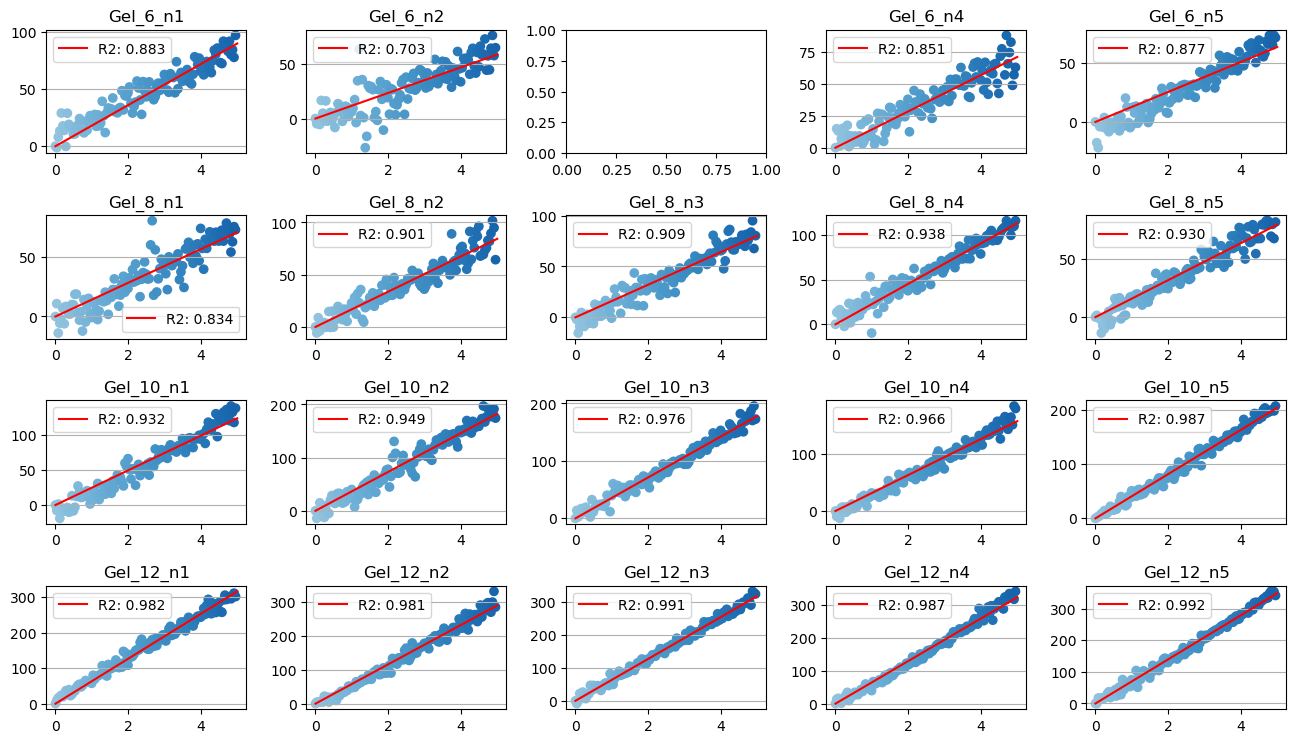

In [5]:
samples=sorted(samples,key=lambda x: int(x[0:2]))
regression_param={}
E=np.zeros((4,5))
residual_strain=np.zeros((4,5))
max_stress=np.zeros((4,5))
hysteresis = np.zeros((4,5))
#residual_strain = np.zeros((4,5))
#max_stress=np.zeros((4,5))
fig, ax = plt.subplots(4, 5,figsize=(16,9),dpi=100)
fig.subplots_adjust(wspace=0.3, hspace=0.5)
c=0
for i in range(4):
    for j in range(5):
        item = samples[c]
        if item == '063':
            c+=1
            E[i,j]='NaN'
            residual_strain[i,j]='NaN'
            max_stress[i,j]='NaN'
            hysteresis[i,j]='NaN'
            continue
        ax[i,j].grid(True,which='major', axis='y')
        index005 = df_coll[item]['Compressive strain (Displacement)'][df_coll[item]['Compressive strain (Displacement)']<=5].idxmax()
        x=df_coll[item]["Compressive strain (Displacement)"][0:index005].values.reshape((-1, 1))
        y=df_coll[item]["Stress norm"][0:index005]
        model = LinearRegression(fit_intercept=False).fit(x, y)
        r_sq = model.score(x, y)
        #print(item,'coefficient of determination:', r_sq)
        #print(item,'intercept:', model.intercept_)
        #print(item,'slope:', model.coef_*100/1000)
        regression_param[samples[c]]={}
        regression_param[samples[c]]['slope']=model.coef_/10
        regression_param[samples[c]]['r']=model.score(x, y)
        E[i,j]=model.coef_/10 # kPa
        max_stress[i,j]=df_coll[item]['Stress norm'].max()

        pos = df_coll[item]['Stress norm']>0
        pos1 = df_coll[item]['Stress norm'][pos]
        idxmax=df_coll[item]['Stress norm'][pos].idxmax()
        upward=df_coll[item]['Stress norm'][pos][:idxmax]
        downward=df_coll[item]['Stress norm'][pos][idxmax:]
        area1 = np.trapz(upward,df_coll[item]['Compressive strain (Displacement)'][pos][:idxmax])
        area2 = np.trapz(downward,df_coll[item]['Compressive strain (Displacement)'][pos][idxmax:])
        hysteresis[i,j]=(area1+area2)/100
        
        idxmax=df_coll[item]['Stress norm'].idxmax()
        upward=df_coll[item][:idxmax]
        downward=df_coll[item][idxmax:]
        residual_strain[i,j]=downward["Compressive strain (Displacement)"][downward['Stress norm']<=0.5].max()
        ax[i, j].scatter(x,y,color=color)
        ax[i, j].plot(np.linspace(0,5,100), np.linspace(0,5,100)*model.coef_, '-r')
        ax[i,j].set_title("Gel_"+str((i+3)*2)+"_n"+str(j+1))
        ax[i,j].legend(['R2: '+'%.3f' % model.score(x,y)])
        c+=1

In [6]:
elastic_mods = pd.DataFrame(data=E, index=['Gel 6', 'Gel 8', 'Gel 10','Gel 12']).transpose() 
residual_strain=pd.DataFrame(data=residual_strain, index=['Gel 6', 'Gel 8', 'Gel 10','Gel 12']).transpose()
max_stress=pd.DataFrame(data=max_stress/1000, index=['Gel 6', 'Gel 8', 'Gel 10','Gel 12']).transpose()
hysteresis=pd.DataFrame(data=hysteresis, index=['Gel 6', 'Gel 8', 'Gel 10','Gel 12']).transpose()

In [7]:
path = r'C:\Users\heiji\OneDrive - Imperial College London\Lymph\Data\\'
swell = pd.read_excel(path+"2021-Feb-15 Swelling Assay.xlsx","Calc2",usecols="A:H")
before = swell.iloc[:,:4]
after = swell.iloc[:,4:]
before_mean = before.mean()
after_mean = after.mean()
before_std = before.std()
after_std= after.std()
volume_ratio = after/before.values[0,:]
volume_ratio_6= pd.concat([pd.DataFrame(np.array(volume_ratio.mean()).reshape(1,4),columns=['Gel 6', 'Gel 8', 'Gel 10','Gel 12']) for i in range(5)],
          ignore_index=True)

weight_before = pd.read_excel(path+"2021-Feb-15 Swelling Assay.xlsx","0 hr",usecols="O:R",nrows=5,skiprows=2)
weight_after = pd.read_excel(path+"2021-Feb-15 Swelling Assay.xlsx","504 hr",usecols="N:Q",nrows=5)
weight_ratio = weight_after/weight_before

In [8]:
rho = 1.369 # g/ml
R = 8314000 # J/mol K
T = 294.15 # K

Mc = (3*rho*R*T)/(elastic_mods*1000)

alpha = 2
Mr = 100 # g/mol

epsilon1 = 2*alpha*np.sqrt(Mc/Mr)
epsilon2 = 2.21*np.power(volume_ratio_6,1/3)
mesh_size = epsilon1*epsilon2/10 #nm

In [9]:
path = r'C:\Users\heiji\OneDrive - Imperial College London\Lymph\Data\\'
file = '2021-Feb-15 Swelling Assay.xlsx'
gel_fraction = pd.read_excel(path+file,"Calc2",usecols="Q:T",nrows=5)
swell_6 = pd.read_excel(path+file,"Calc",usecols="C:J",header=1,nrows=5)
swell_8 = pd.read_excel(path+file,"Calc",usecols="C:J",header=None,nrows=5,skiprows=9,names=swell_6.columns)
swell_10 = pd.read_excel(path+file,"Calc",usecols="C:J",header=None,nrows=5,skiprows=16,names=swell_6.columns)
swell_12 = pd.read_excel(path+file,"Calc",usecols="C:J",header=None,nrows=5,skiprows=23,names=swell_6.columns)

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def stats_test_print(values_o):
    global alpha
    alpha = 0.05
    values=values_o.dropna()
    for i in range(4):
        shapiro_p=stats.shapiro(values.iloc[:,i]).pvalue #is the first group normal?
        if shapiro_p>alpha:
            anova_p = stats.f_oneway(values.iloc[:,0],values.iloc[:,1],values.iloc[:,2],values.iloc[:,3]).pvalue 
            if anova_p<alpha:
                alpha_corr=alpha/4 #Bonferroni correction
                for j in range(i+1,4):
                    shapiro_p = stats.shapiro(values.iloc[:,j]).pvalue #is the second group normal?
                    if shapiro_p > alpha:
                        multi_compar_p =stats.ttest_ind(values.iloc[:,i],values.iloc[:,j]).pvalue 
                        if multi_compar_p < alpha_corr:
                            print(values.columns[i]+" and "+values.columns[j],stats.ttest_ind(values.iloc[:,i],values.iloc[:,j]))
                    else:
                        print(values.columns[j],"not normal",shapiro_p)
            else:
                print("ANOVA not sig")
        else:
            print(values.columns[i],shapiro_p,"not normal")
            kruskal_p = stats.kruskal(values.iloc[:,0],values.iloc[:,1],values.iloc[:,2],values.iloc[:,3]).pvalue 
            if kruskal_p<alpha:
                print("Kruskal ok",kruskal_p)
                alpha_corr=alpha/4
                for j in range(i+1,4):
                    shapiro_p = stats.shapiro(values.iloc[:,j]).pvalue #is the second group normal?
                    if shapiro_p > alpha:
                        multi_compar_p =stats.ttest_ind(values.iloc[:,i],values.iloc[:,j]).pvalue 
                        if multi_compar_p < alpha_corr:
                            print(values.columns[i]+" and "+values.columns[j],stats.mannwhitneyu(values.iloc[:,i],values.iloc[:,j]))
                    else:
                        print(values.columns[j],"not normal",shapiro_p)
    print('\n')

def stats_two(values,i,j):
    return stats.ttest_ind(values.dropna().iloc[:,i],values.iloc[:,j]).pvalue

def label_diff(i,j,X,Y):
    Ym = Y.mean()
    x = (X[i]+X[j])/2
    y = 1.1*max(Ym[i],Ym[j])
    dx = abs(X[i]-X[j])
    ytext = 0.7*min(Ym[i],Ym[j])+0.9*max(Ym[i],Ym[j])

    props = {'connectionstyle':'angle','arrowstyle':'-',\
                 'shrinkA':7,'shrinkB':7,'linewidth':0.5}
    #text = 'p = '+'%.2e' %stats_two(Y,i,j)
    p = stats_two(Y,i,j)
    text = ''
    if p < 0.001:
        text = '***'
    elif p< 0.01:
        text = '**'
    elif p<0.05:
        text = "*"
    plt.annotate(text, xy=(x,ytext*1.007),zorder=10,color="black",ha='center',fontsize=8)
    plt.annotate('', xy=(X[i],ytext), xytext=(X[j],ytext), arrowprops=props)

In [11]:
import seaborn as sns
blue = cm.Blues(np.linspace(.4, .8, 4))

path = r'C:\Users\heiji\OneDrive - Imperial College London\Lymph\Data\\'
degrade = pd.read_excel(path+"2021-Apr-27 Zymography.xlsx","Summary")

plt.figure(figsize=(10,8),dpi=300)
sns.set_palette(blue)


<Figure size 3000x2400 with 0 Axes>

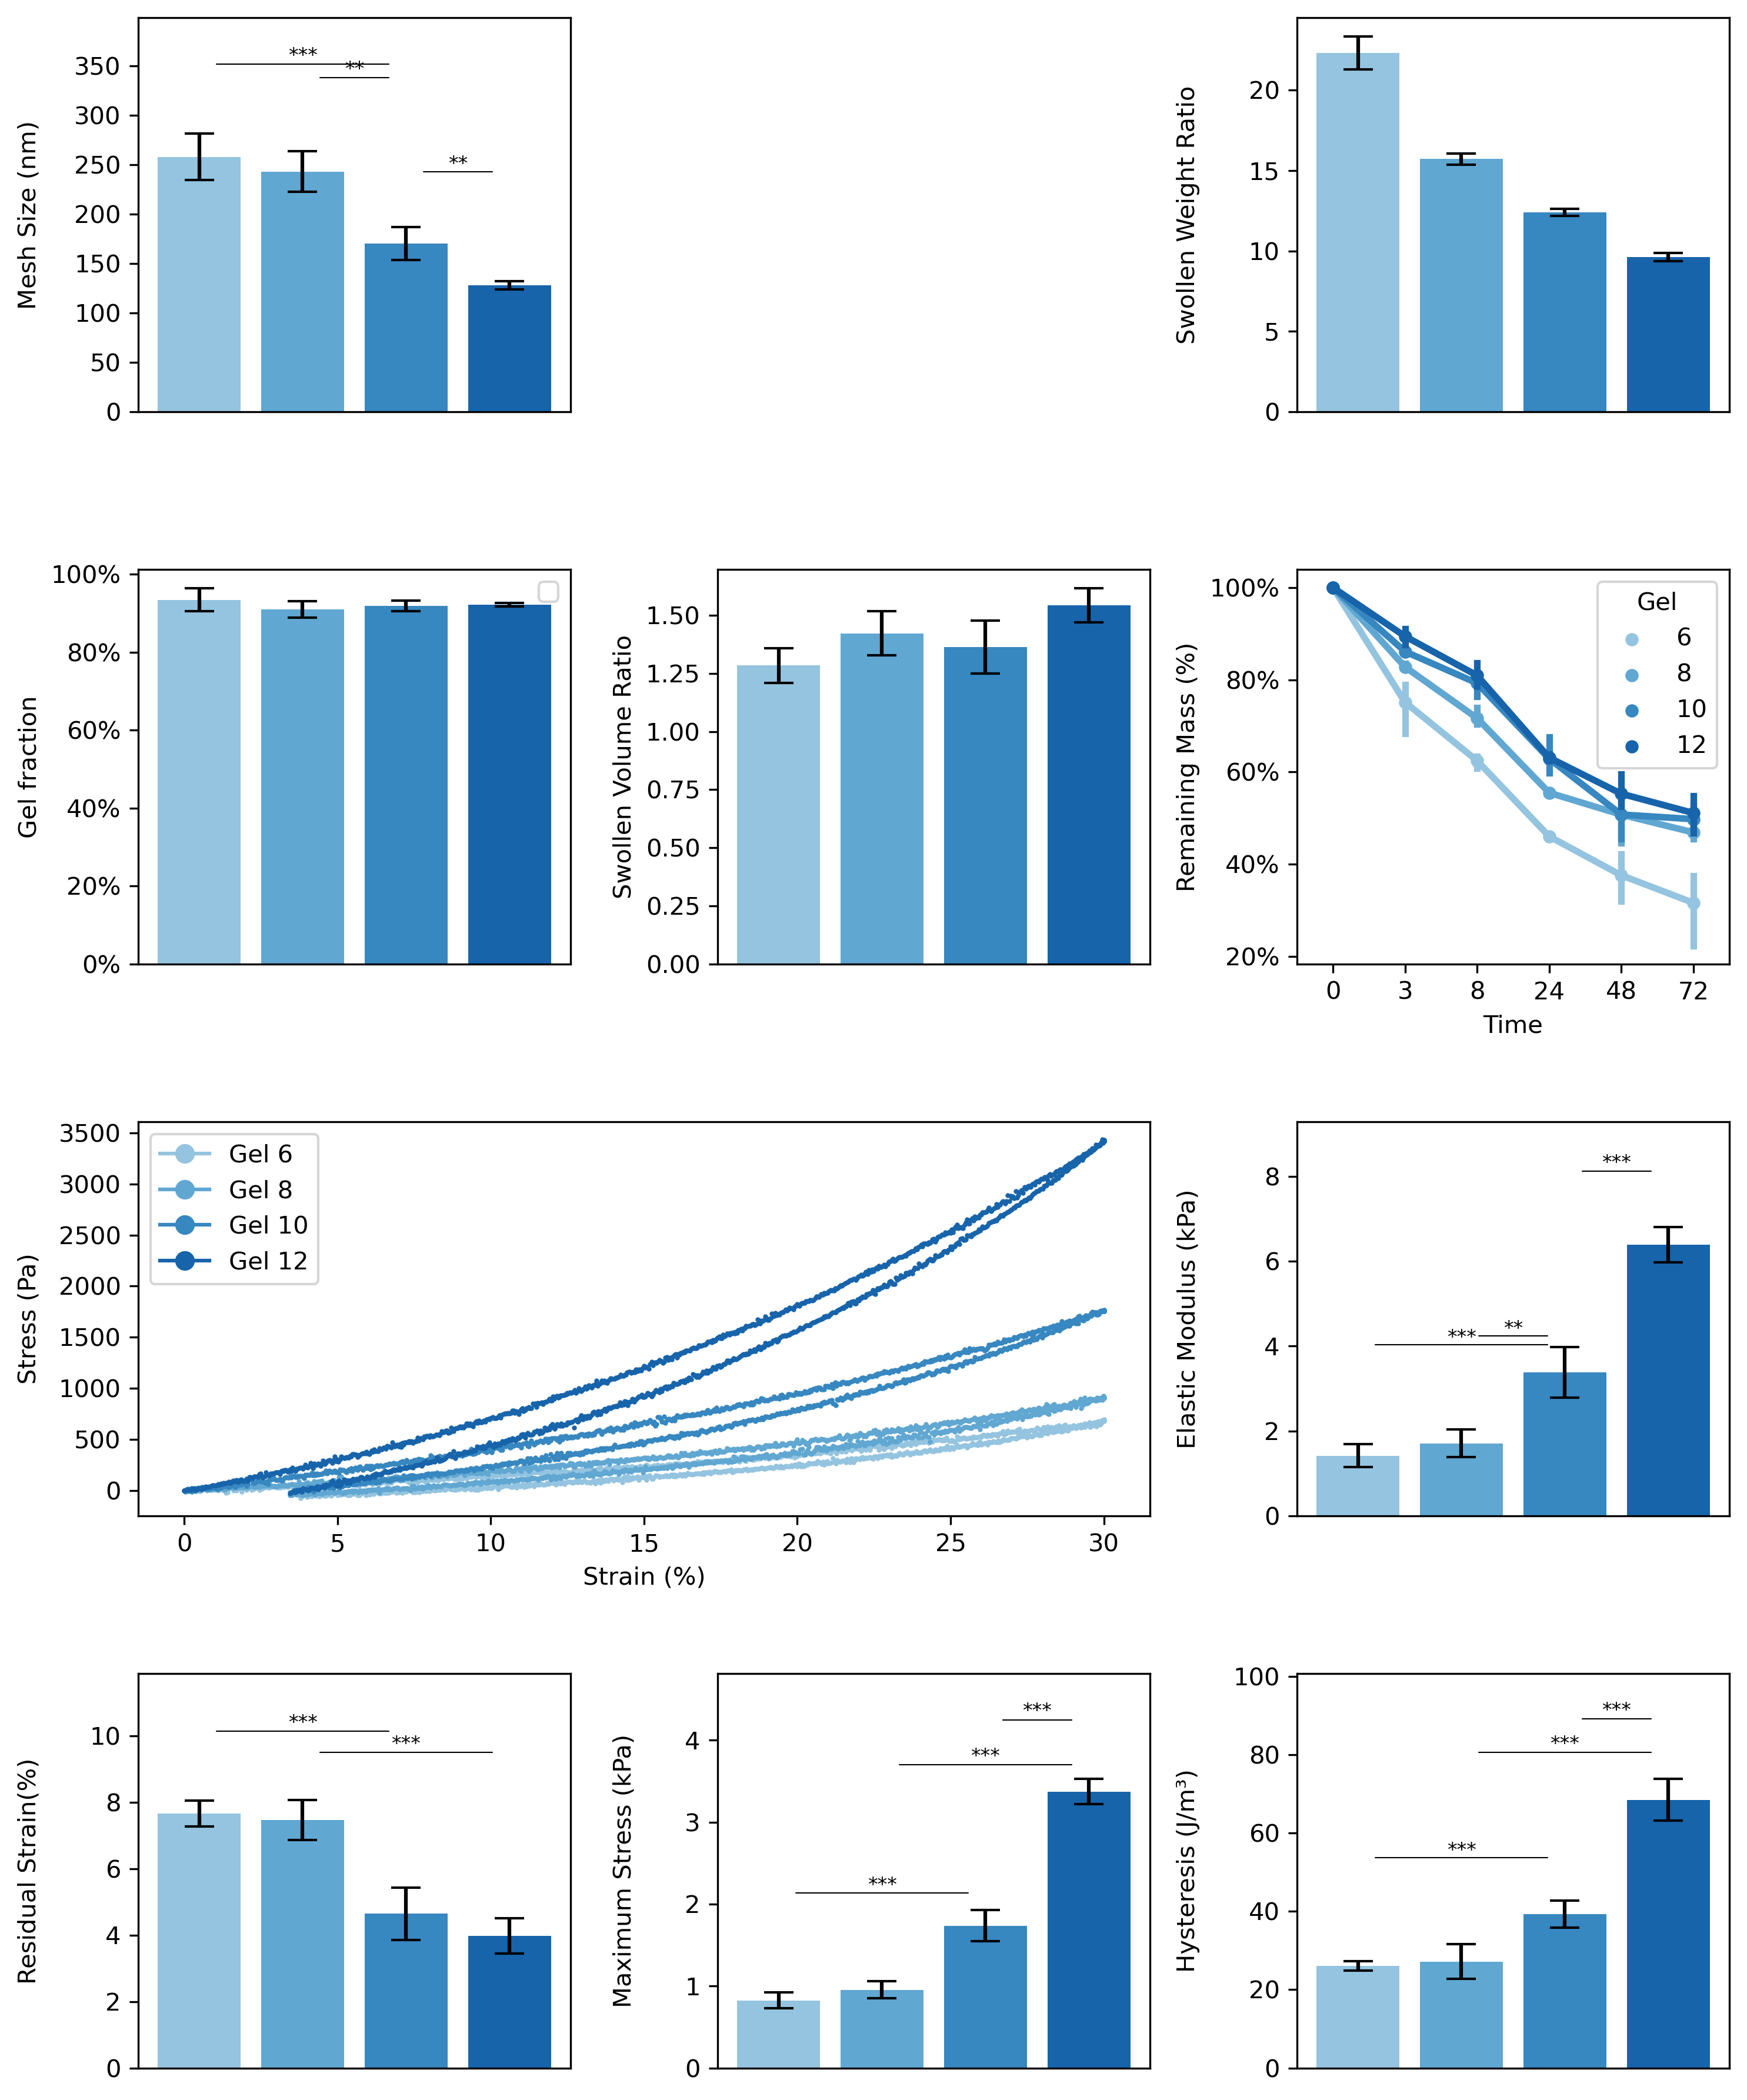

In [12]:
ind  = np.arange(1,5)
color = cm.Blues(np.linspace(.4, .8, 4))
bar_format = {'align':'center','capsize':6,'color':color}
ebr_format = {'capsize':3}
#fig, ax = plt.subplots(3, 2,figsize=(16,10),dpi=200)
fig=plt.figure(figsize=(10,12),dpi=300)
#plt.subplots_adjust(hspace=0.2,wspace=0.6)

#---------------------Swelling----------------------------
ax2=plt.subplot2grid((4, 3), (0,0),colspan=2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
x=[0,2,6,24,72,144,366,504]
plt.errorbar(x,swell_6.mean(),yerr=swell_6.std(),**ebr_format,color=color[0])
plt.errorbar(x,swell_8.mean(),yerr=swell_8.std(),**ebr_format,color=color[1])
plt.errorbar(x,swell_10.mean(),yerr=swell_10.std(),**ebr_format,color=color[2])
plt.errorbar(x,swell_12.mean(),yerr=swell_12.std(),**ebr_format,color=color[3])
plt.ylabel("Weight Variation(%)")
plt.xlabel("Time (h)")
#plt.legend(['Gel_6','Gel_8','Gel_10','Gel_12'],loc=4,fontsize=6)


#---------------------Weight Ratio----------------------------
plt.subplot2grid((4, 3), (0, 2))
plt.bar(ind,weight_ratio.mean(),yerr=weight_ratio.std(),**bar_format)
plt.ylabel("Swollen Weight Ratio")
plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


#---------------------Gel Fraction----------------------------
ax=plt.subplot2grid((4, 3), (1,0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.bar(ind,gel_fraction.mean(),yerr=gel_fraction.std(),**bar_format)
plt.ylabel("Gel fraction")
plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'],fontsize=7)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


#---------------------Swelling Volume---------------------------
plt.subplot2grid((4, 3), (1, 1))
plt.bar(ind,volume_ratio.mean(),yerr=volume_ratio.std(),**bar_format)
plt.ylabel("Swollen Volume Ratio")
plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

#---------------------Mesh Size----------------------------
ax_m=plt.subplot2grid((4, 3), (0, 0))
plt.bar(ind,mesh_size.mean(),yerr=mesh_size.std(),**bar_format)
plt.ylabel("Mesh Size (nm)")
#plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(ymax=ax_m.get_ylim()[1]*1.35)
label_diff(0,2,ind,mesh_size)
label_diff(2,3,ind,mesh_size)
label_diff(1,2,ind,mesh_size)

#---------------------test----------------------------
ax_test=plt.subplot2grid((4, 3), (1, 2))

sns.pointplot(x="Time", y="Gel Percent", hue="Gel", data=degrade,legend=False,linewidth=2,markers=".",ax=ax_test)
plt.ylabel("Remaining Mass (%)")
ax.legend([])
ax_test.yaxis.set_major_formatter(mtick.PercentFormatter(1))

#---------------------Elastic Mods----------------------------
ax_e=plt.subplot2grid((4, 3), (2,2))
plt.bar(ind,elastic_mods.mean(),yerr=elastic_mods.std(),**bar_format)
#plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Elastic Modulus (kPa)')
plt.ylim(ymax=ax_e.get_ylim()[1]*1.3)
label_diff(0,2,ind,elastic_mods)
label_diff(2,3,ind,elastic_mods)
label_diff(1,2,ind,elastic_mods)

#---------------------Residual Strain----------------------------
ax_r=plt.subplot2grid((4, 3), (3, 0))
plt.bar(ind,residual_strain.mean(),yerr=residual_strain.std(),**bar_format)
#plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Residual Strain(%)")
plt.ylim(ymax=ax_r.get_ylim()[1]*1.4)
label_diff(0,2,ind,residual_strain)
label_diff(1,3,ind,residual_strain)

#---------------------Max Stress----------------------------
ax_m=plt.subplot2grid((4, 3), (3, 1))
plt.bar(ind,max_stress.mean(),yerr=max_stress.std(),**bar_format)
#plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Maximum Stress (kPa)")
plt.ylim(ymax=ax_m.get_ylim()[1]*1.3)
label_diff(0,2,ind,max_stress)
label_diff(1,3,ind,max_stress)
label_diff(2,3,ind,max_stress)

#---------------------Hysteresis----------------------------
ax=plt.subplot2grid((4, 3), (3, 2))
plt.bar(ind,hysteresis.mean(),yerr=hysteresis.std(),**bar_format)
#plt.xticks(ind,['Gel_6','Gel_8','Gel_10','Gel_12'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Hysteresis (J/m³)")
plt.ylim(ymax=ax.get_ylim()[1]*1.3)
label_diff(0,2,ind,hysteresis)
label_diff(1,3,ind,hysteresis)
label_diff(2,3,ind,hysteresis)

#---------------------Mechanical Test----------------------------
plt.subplot2grid((4, 3), (2,0),colspan=2)
for i in range(1,19,5):
    item = samples[i]
    i+=1
    color1 = color[0]
    if item == '063':
        continue
    if item[:2] == '06':
        color1 = color[0]
    elif item[:2] == "08":
        color1 = color[1]
    elif item[:2] == "10":
        color1 = color[2]
    else:
        color1 = color[3]
    plt.scatter(df_coll[item]["Compressive strain (Displacement)"],df_coll[item]["Stress norm"],s=1,color=color1)
    
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker='o', color=color[0], label='Scatter',
                          markerfacecolor=color[0], markersize=7),
                Line2D([0], [0], marker='o', color=color[1], label='Scatter',
                          markerfacecolor=color[1], markersize=7),
                Line2D([0], [0], marker='o', color=color[2], label='Scatter',
                          markerfacecolor=color[2], markersize=7),
               Line2D([0], [0], marker='o', color=color[3], label='Scatter',
                          markerfacecolor=color[3], markersize=7)]
plt.ylabel("Stress (Pa)")
plt.xlabel("Strain (%)")


fig.align_ylabels()
plt.tight_layout()

plt.subplots_adjust(hspace=0.4)
plt.legend(custom_lines, ['Gel 6', 'Gel 8', 'Gel 10','Gel 12'])

In [13]:
def tukeys(values,gel6): #in mechanical n=4 for gel6 but for swelling n=5
#    df = pd.DataFrame({'score': values.transpose().values.flatten(),
#                   }).dropna()
#    df['group'] = np.repeat(['Gel_6','Gel_8','Gel_10','Gel_12'], repeats=[gel6,5,5,5])

    stacked_data = values.stack().reset_index()
    stacked_data = stacked_data.rename(columns={'level_1': 'group',
                                            0:'score'})
    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=stacked_data['score'],
                          groups=stacked_data['group'],
                          alpha=0.05)

    #display results
    print(tukey,'\n')

In [14]:
print('vol ratio')
stats_test_print(volume_ratio)
tukeys(volume_ratio,5)
print('weight ratio')
stats_test_print(weight_ratio)
tukeys(weight_ratio,5)

print('gel_fraction')
stats_test_print(gel_fraction)
tukeys(gel_fraction,5)

print('mesh size')
stats_test_print(mesh_size)
tukeys(mesh_size,4)

print('elastic mods')
stats_test_print(elastic_mods)
tukeys(elastic_mods,4)

print('max_stress')
stats_test_print(max_stress)
tukeys(max_stress,4)

print('hysteresis')
stats_test_print(hysteresis)
tukeys(hysteresis,4)

print('residual strain')
stats_test_print(residual_strain)
tukeys(residual_strain,4)

vol ratio
After Gel 6 and After Gel 12 Ttest_indResult(statistic=-5.576919466596553, pvalue=0.0005241853119219559)


      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
After Gel 10 After Gel 12   0.1801 0.0288  0.0162   0.344   True
After Gel 10  After Gel 6  -0.0789 0.5286 -0.2428   0.085  False
After Gel 10  After Gel 8   0.0592 0.7132 -0.1047  0.2231  False
After Gel 12  After Gel 6   -0.259 0.0018 -0.4229 -0.0951   True
After Gel 12  After Gel 8  -0.1209 0.1918 -0.2848   0.043  False
 After Gel 6  After Gel 8   0.1381 0.1151 -0.0258   0.302  False
---------------------------------------------------------------- 

weight ratio
Gel 6 0.04688258096575737 not normal
Kruskal ok 0.0004707189529993288
Gel 8 not normal 0.020502524450421333
Gel 6 and Gel 10 MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Gel 6 and Gel 12 MannwhitneyuR

In [15]:
volume_ratio.mean()

After Gel 6     1.284314
After Gel 8     1.422406
After Gel 10    1.363169
After Gel 12    1.543299
dtype: float64

In [16]:
stacked_data = hysteresis.stack().reset_index()
print(stacked_data)
stacked_data = stacked_data.rename(columns={'level_1': 'group',
                                            0:'score'})
print(stacked_data)
stacked_data.head()
tukey = pairwise_tukeyhsd(endog=stacked_data['score'],
                          groups=stacked_data['group'],
                          alpha=0.05)
print(vars(tukey),'\n')
    # perform Tukey's test

    level_0 level_1          0
0         0   Gel 6  27.417543
1         0   Gel 8  22.639897
2         0  Gel 10  37.046962
3         0  Gel 12  68.083302
4         1   Gel 6  24.578102
5         1   Gel 8  23.944004
6         1  Gel 10  40.146843
7         1  Gel 12  59.887795
8         2   Gel 8  26.789748
9         2  Gel 10  39.592974
10        2  Gel 12  71.082320
11        3   Gel 6  25.940626
12        3   Gel 8  34.035030
13        3  Gel 10  35.315314
14        3  Gel 12  73.935613
15        4   Gel 6  26.528286
16        4   Gel 8  28.431118
17        4  Gel 10  44.419169
18        4  Gel 12  69.318350
    level_0   group      score
0         0   Gel 6  27.417543
1         0   Gel 8  22.639897
2         0  Gel 10  37.046962
3         0  Gel 12  68.083302
4         1   Gel 6  24.578102
5         1   Gel 8  23.944004
6         1  Gel 10  40.146843
7         1  Gel 12  59.887795
8         2   Gel 8  26.789748
9         2  Gel 10  39.592974
10        2  Gel 12  71.082320
11      

In [17]:
elastic_mods.stack().reset_index()

,level_0,level_1,0
0,0,Gel 6,1.795521
1,0,Gel 8,1.419194
2,0,Gel 10,2.480659
3,0,Gel 12,6.332066
4,1,Gel 6,1.173278
5,1,Gel 8,1.687233
6,1,Gel 10,3.654305
7,1,Gel 12,5.810255
8,2,Gel 8,1.603368
9,2,Gel 10,3.562374


In [18]:
swell_6

,0,2,6,24,72,144,366,504
0,0,7.985915,10.788732,15.563380,18.718310,20.873239,21.563380,22.507042
1,0,6.392405,9.721519,14.075949,16.708861,19.088608,20.582278,20.265823
2,0,5.081395,8.406977,13.395349,15.860465,17.941860,18.755814,18.593023
3,0,5.600000,8.717647,14.105882,17.152941,19.400000,18.917647,18.482353
4,0,6.928571,9.547619,13.488095,16.785714,19.095238,18.964286,19.583333


In [19]:
elastic_mods.mean()

Gel 6     1.417728
Gel 8     1.710913
Gel 10    3.384597
Gel 12    6.387113
dtype: float64